# EDA

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

## Load Words

In [2]:
words_12k = pd.read_csv('words_12k.csv')
words_5k = pd.read_csv('words_5k.csv')

## Game Logic

In [3]:
def wordle(input_word, solution):
    output = ''
    for i in range(5):
        if input_word[i] == solution[i]:
            output += 'G'
        elif input_word[i] in solution:
            output += 'Y'
        else:
            output += 'X'
    return output

In [4]:
def filter_wordset(input_word, feedback, wordset):
    newset = wordset.copy()
    for i in range(5):
        if feedback[i] == 'G':
            newset = newset.loc[newset.word.str[i] == input_word[i]]
        elif feedback[i] == 'Y':
            # newset = newset.loc[newset.word.str.contains(input_word[i])]
            newset = newset.loc[newset.word.str.contains(input_word[i]) & newset.word.apply(lambda x: x[i] != input_word[i])]
        else:
            newset = newset.loc[~newset.word.str.contains(input_word[i])]
    return newset

In [5]:
def compute_letter_distribution(wordset):
    w = wordset.copy()
    for letter in list('abcdefghijklmnopqrstuvwxyz'):
        w[letter] = w.word.str.contains(letter).astype(int)
    return w.iloc[:, 1:]

In [6]:
def compute_score(x, freqs):
    letters = set(x)
    output = 0
    for letter in letters:
        output += freqs[letter]
    return output

## Pre-compute

In [7]:
global_freqs = compute_letter_distribution(words_12k).sum().to_dict()

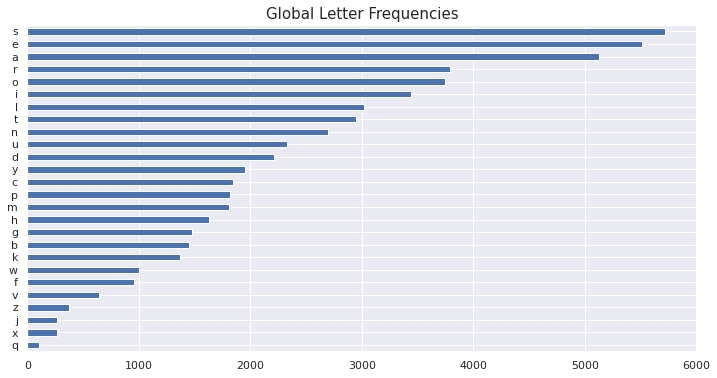

In [20]:
compute_letter_distribution(words_12k).sum().sort_values().plot.barh(figsize=(12,6))
plt.title('Global Letter Frequencies', fontdict={'fontsize': 15})
plt.show()

In [21]:
global_scores = words_12k.word.apply(compute_score, freqs=global_freqs)
global_scores = pd.DataFrame({'word': words_12k.word, 'score': global_scores}).sort_values('score', ascending=False)

In [22]:
global_scores.head(50)

,word,score
136,aeros,23886
534,arose,23886
9966,soare,23886
8501,raise,23580
9415,serai,23580
518,arise,23580
137,aesir,23580
5853,laser,23159
5917,lears,23159
3131,earls,23159


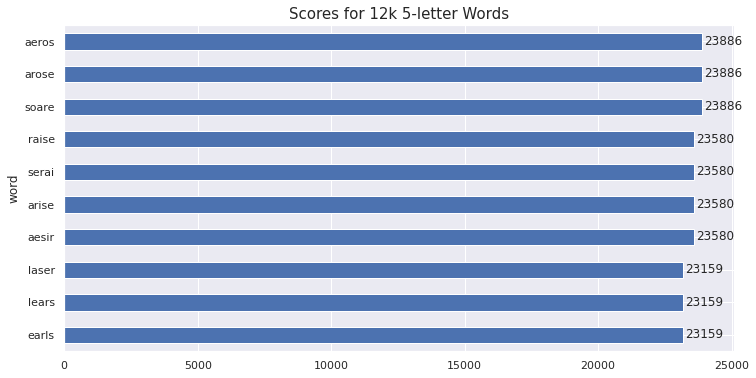

In [36]:
plot_words = global_scores.head(10).reset_index(drop=True)
plot_words.set_index('word').plot.barh(figsize=(12,6), legend=None)
plt.gca().invert_yaxis()
plt.title('Scores for 12k 5-letter Words', fontdict={'fontsize': 15})
for i, row in plot_words.iterrows():
    plt.text(row.score+100, i+0.1, row.score)
plt.show()

### First and Last Letters

In [302]:
words_12k.word.str[0].value_counts()

s    1521
c     888
b     871
p     821
t     787
a     715
m     666
d     650
r     610
g     608
f     575
l     551
h     477
w     402
k     353
n     317
e     288
o     257
v     231
j     191
u     178
y     175
i     157
z      98
q      76
x      15
Name: word, dtype: int64

In [303]:
words_12k.word.str[-1].value_counts()

s    3805
e    1477
y    1254
d     807
t     710
r     656
a     632
n     512
l     465
o     365
h     349
i     253
k     244
m     179
p     146
g     135
c     124
f      80
x      65
u      63
w      62
b      55
z      31
v       4
q       3
j       2
Name: word, dtype: int64

## Algorithm

In [229]:
words_5k.sample(n=1).word

1936    droop
Name: word, dtype: object

In [304]:
solution = 'robot'
input_word = 'pares'
feedback = ''
wordset = words_5k.copy()
tested_words = []
n_iter = 1

print(f'Solution: {solution}')
while feedback != 'GGGGG':
    
    # Check solution
    feedback = wordle(input_word, solution)
    print(f'[{n_iter}] Input: {input_word} | Feedback: {feedback}')
    tested_words.append(input_word)
    
    # Filter wordset
    wordset = filter_wordset(input_word, feedback, wordset)
    wordset = wordset.loc[~wordset.word.isin(tested_words)]
    print('wordset size:', wordset.shape[0])
    
    # Compute letter distribution of updated wordset
    wordset_letterdist = compute_letter_distribution(wordset)
    freqs = wordset_letterdist.sum().to_dict()
    
    # Obtain scores
    scores = wordset.word.apply(compute_score, freqs=freqs)
    scores = pd.DataFrame({'word': wordset.word, 'score': scores}).sort_values('score', ascending=False)
    
    # Set new input word
    if scores.shape[0] > 0:
        input_word = scores.word.iloc[0]
        n_iter += 1

Solution: robot
[1] Input: pares | Feedback: XXYXX
wordset size: 160
[2] Input: intro | Feedback: XXYYY
wordset size: 11
[3] Input: broth | Feedback: YYYYX
wordset size: 1
[4] Input: robot | Feedback: GGGGG
wordset size: 0


In [244]:
def sim_wordle(input_word, solution):
    feedback = ''
    wordset = words_5k.copy()
    tested_words = []
    n_iter = 1

    while feedback != 'GGGGG':

        # Check solution
        feedback = wordle(input_word, solution)
        tested_words.append(input_word)

        # Filter wordset
        wordset = filter_wordset(input_word, feedback, wordset)
        wordset = wordset.loc[~wordset.word.isin(tested_words)]

        # Compute letter distribution of updated wordset
        wordset_letterdist = compute_letter_distribution(wordset)
        freqs = wordset_letterdist.sum().to_dict()

        # Obtain scores
        scores = wordset.word.apply(compute_score, freqs=freqs)
        scores = pd.DataFrame({'word': wordset.word, 'score': scores}).sort_values('score', ascending=False)

        # Set new input word
        if scores.shape[0] > 0:
            input_word = scores.word.iloc[0]
            n_iter += 1
    return n_iter

In [250]:
input_word

'robot'

In [245]:
from tqdm.notebook import tqdm

from joblib import Parallel, delayed

### Adieu

In [251]:
input_word = 'adieu'
results = Parallel(n_jobs=5, verbose=3)(delayed(sim_wordle)(input_word, s) for s in words_5k.word)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   19.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   30.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   45.1s
[Parallel(n_jobs=5)]: Done 3106 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 4066 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 5154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 5748 out of 5757 | elapsed:  2.0min remaining:    0.2s
[Parallel(n_jobs=5)]: Done 5757 out of 5757 | elapsed:  2.0min finished


,count,mean,std,min,25%,50%,75%,max
0,5757.0,4.428869,1.363434,1.0,4.0,4.0,5.0,13.0


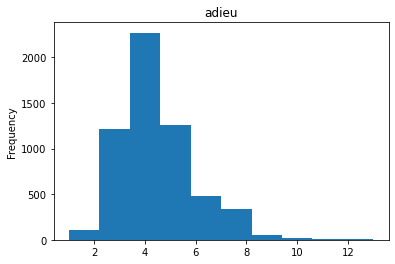

In [256]:
performance = pd.Series(results)
display(pd.DataFrame(performance.describe()).T)

performance.plot.hist()
plt.title(input_word)
plt.show()

### Raise

In [257]:
input_word = 'raise'
results2 = Parallel(n_jobs=5, verbose=3)(delayed(sim_wordle)(input_word, s) for s in words_5k.word)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   20.2s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   37.5s
[Parallel(n_jobs=5)]: Done 3110 tasks      | elapsed:   60.0s
[Parallel(n_jobs=5)]: Done 4518 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 5748 out of 5757 | elapsed:  1.9min remaining:    0.2s
[Parallel(n_jobs=5)]: Done 5757 out of 5757 | elapsed:  1.9min finished


,count,mean,std,min,25%,50%,75%,max
0,5757.0,4.329164,1.361081,1.0,3.0,4.0,5.0,12.0


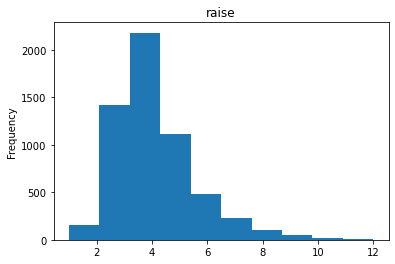

In [263]:
performance2 = pd.Series(results2)
display(pd.DataFrame(performance2.describe()).T)

performance2.plot.hist()
plt.title(input_word)
plt.show()

### Aeros

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   17.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   27.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   41.4s
[Parallel(n_jobs=5)]: Done 3106 tasks      | elapsed:   58.3s
[Parallel(n_jobs=5)]: Done 4066 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 5154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 5757 out of 5757 | elapsed:  1.9min finished


,count,mean,std,min,25%,50%,75%,max
0,5757.0,4.340803,1.364658,2.0,3.0,4.0,5.0,12.0


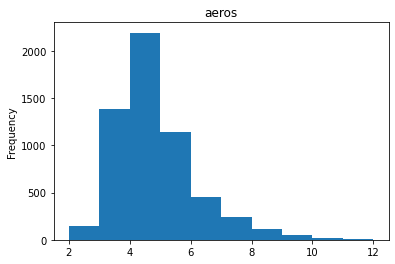

In [264]:
input_word = 'aeros'
results_aeros = Parallel(n_jobs=5, verbose=3)(delayed(sim_wordle)(input_word, s) for s in words_5k.word)
performance_aeros = pd.Series(results_aeros)
display(pd.DataFrame(performance_aeros.describe()).T)

performance_aeros.plot.hist()
plt.title(input_word)
plt.show()

### Notes

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   18.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   35.1s
[Parallel(n_jobs=5)]: Done 3110 tasks      | elapsed:   57.3s
[Parallel(n_jobs=5)]: Done 4518 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 5748 out of 5757 | elapsed:  1.9min remaining:    0.2s
[Parallel(n_jobs=5)]: Done 5757 out of 5757 | elapsed:  1.9min finished


,count,mean,std,min,25%,50%,75%,max
0,5757.0,4.295293,1.351267,1.0,3.0,4.0,5.0,13.0


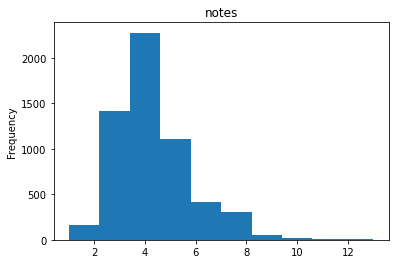

In [267]:
input_word = 'notes'
results_aeros = Parallel(n_jobs=5, verbose=3)(delayed(sim_wordle)(input_word, s) for s in words_5k.word)
performance_aeros = pd.Series(results_aeros)
display(pd.DataFrame(performance_aeros.describe()).T)

performance_aeros.plot.hist()
plt.title(input_word)
plt.show()

### Resin

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.1s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   46.9s
[Parallel(n_jobs=5)]: Done 3106 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 4066 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 5154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 5757 out of 5757 | elapsed:  2.1min finished


,count,mean,std,min,25%,50%,75%,max
0,5757.0,4.306236,1.321306,1.0,3.0,4.0,5.0,13.0


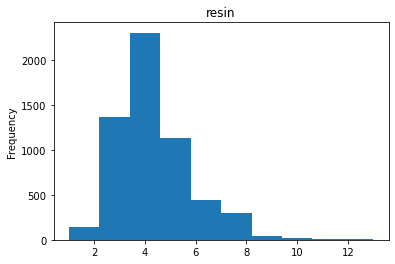

In [268]:
input_word = 'resin'
results_aeros = Parallel(n_jobs=5, verbose=3)(delayed(sim_wordle)(input_word, s) for s in words_5k.word)
performance_aeros = pd.Series(results_aeros)
display(pd.DataFrame(performance_aeros.describe()).T)

performance_aeros.plot.hist()
plt.title(input_word)
plt.show()

### Tares

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.3s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   47.1s
[Parallel(n_jobs=5)]: Done 3106 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 4066 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 5154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 5748 out of 5757 | elapsed:  2.1min remaining:    0.2s
[Parallel(n_jobs=5)]: Done 5757 out of 5757 | elapsed:  2.1min finished


,count,mean,std,min,25%,50%,75%,max
0,5757.0,4.231023,1.292031,1.0,3.0,4.0,5.0,12.0


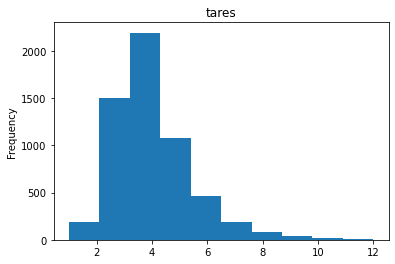

In [269]:
input_word = 'tares'
results_aeros = Parallel(n_jobs=5, verbose=3)(delayed(sim_wordle)(input_word, s) for s in words_5k.word)
performance_aeros = pd.Series(results_aeros)
display(pd.DataFrame(performance_aeros.describe()).T)

performance_aeros.plot.hist()
plt.title(input_word)
plt.show()

### Senor

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   17.7s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   28.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   41.8s
[Parallel(n_jobs=5)]: Done 3106 tasks      | elapsed:   58.7s
[Parallel(n_jobs=5)]: Done 4066 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 5154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 5748 out of 5757 | elapsed:  1.9min remaining:    0.2s
[Parallel(n_jobs=5)]: Done 5757 out of 5757 | elapsed:  1.9min finished


,count,mean,std,min,25%,50%,75%,max
0,5757.0,4.279138,1.302856,2.0,3.0,4.0,5.0,12.0


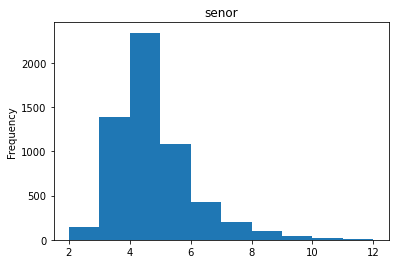

In [270]:
input_word = 'senor'
results_aeros = Parallel(n_jobs=5, verbose=3)(delayed(sim_wordle)(input_word, s) for s in words_5k.word)
performance_aeros = pd.Series(results_aeros)
display(pd.DataFrame(performance_aeros.describe()).T)

performance_aeros.plot.hist()
plt.title(input_word)
plt.show()

## PCA

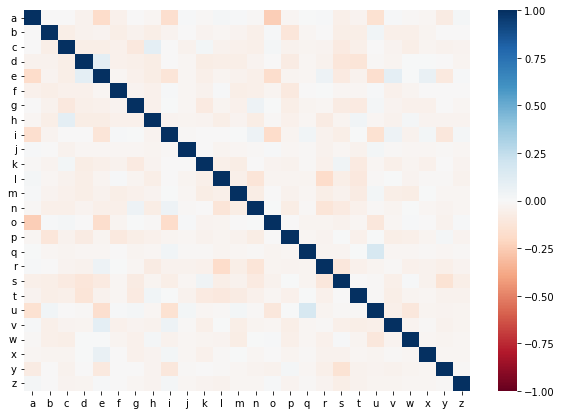

In [283]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(compute_letter_distribution(words_12k).corr(), cmap='RdBu', vmin=-1, vmax=1)
plt.yticks(rotation=0)
plt.show()